# Projet optimisation

In [1]:
import Pkg

Pkg.add("JuMP")
Pkg.add("GLPK")
Pkg.add("Random")
Pkg.add("GLPK")
Pkg.add("Plots")
Pkg.add("Crayons")
Pkg.pin("Plots") # keeps Plots working
Pkg.update()

   Updating registry at `C:\Users\charl\.julia\registries\General`


  Resolving package versions...


No Changes to `C:\Users\charl\.julia\environments\v1.5\Project.toml`
No Changes to `C:\Users\charl\.julia\environments\v1.5\Manifest.toml`
  Resolving package versions...


No Changes to `C:\Users\charl\.julia\environments\v1.5\Project.toml`
No Changes to `C:\Users\charl\.julia\environments\v1.5\Manifest.toml`
  Resolving package versions...


No Changes to `C:\Users\charl\.julia\environments\v1.5\Project.toml`
No Changes to `C:\Users\charl\.julia\environments\v1.5\Manifest.toml`
  Resolving package versions...


No Changes to `C:\Users\charl\.julia\environments\v1.5\Project.toml`
No Changes to `C:\Users\charl\.julia\environments\v1.5\Manifest.toml`
`Plots` is pinned at `v1.15.2`: maintaining pinned version
  Resolving package versions...


No Changes to `C:\Users\charl\.julia\environments\v1.5\Project.toml`
No Changes to `C:\Users\charl\.julia\environments\v1.5\Manifest.toml`
  Resolving package versions...


No Changes to `C:\Users\charl\.julia\environments\v1.5\Project.toml`
No Changes to `C:\Users\charl\.julia\environments\v1.5\Manifest.toml`


package `Plots [91a5bcdd]` already pinned
  Resolving package versions...


No Changes to `C:\Users\charl\.julia\environments\v1.5\Project.toml`
No Changes to `C:\Users\charl\.julia\environments\v1.5\Manifest.toml`


   Updating registry at `C:\Users\charl\.julia\registries\General`


No Changes to `C:\Users\charl\.julia\environments\v1.5\Project.toml`
No Changes to `C:\Users\charl\.julia\environments\v1.5\Manifest.toml`


### Some functions we need :

In [2]:
# Time and cost
function calcCostTime(choice)
    γ = sum(c[i]*choice[i] for i in 1:2n)
    τ = sum(t[i]*choice[i] for i in 1:2n)
    return (γ, τ)
end

# check domination
function isDominated(choice1, choice2)
   return (choice1[1] <= choice2[1] && choice1[2] < choice2[2]) || (choice1[1] < choice2[1] && choice1[2] <= choice2[2])
end

isDominated (generic function with 1 method)

In [21]:
# Global variable delaration
global n = 20
global c = rand(1:100, 2n)
global t = rand(1:100, 2n)

40-element Array{Int64,1}:
 66
 45
  6
 64
 88
 60
 27
 37
 58
 99
  ⋮
  9
  3
 61
 92
 50
  8
 91
 90
 15

## Solving pareto front using Weighted sum method

In [22]:
using Random
using JuMP
using GLPK

function paretofront(n, c, t, w1)
        
  m=Model(GLPK.Optimizer)
  
  # Define our choice variable (0 : don't take this object, 1 : take it)
  @variable(m, x[1:2n], Bin)

  # Define our 2 fonctions we want to minimize
  f1 = @expression(m, sum(c[i]*x[i] for i in 1:2n))
  f2 = @expression(m, sum(t[i]*x[i] for i in 1:2n))
  
  # Define our objective function
  @objective(m, Min, w1*f1 + (1-w1)*f2)

  #contrainte du nombre d'objets
  @constraint(m, sum(x[i] for i in 1:2n) == n)

  #optimisation
  optimize!(m)
  
  return m, x

end

paretofront (generic function with 1 method)

In [23]:
γ_arr = Float64[]
τ_arr = Float64[]


for i in 0:0.01:1
  # Find optimal solution for w1 (here i) fixed
  m_optimal, x_optimal = paretofront(n, c, t, i)
  # Get γ, τ values for this optimal solution
  γ, τ = calcCostTime(JuMP.value.(x_optimal))
  push!(γ_arr, γ)
  push!(τ_arr, τ)
end

τ_arr, γ_arr

([557.0, 557.0, 557.0, 557.0, 557.0, 557.0, 557.0, 557.0, 557.0, 557.0  …  965.0, 965.0, 965.0, 965.0, 965.0, 1007.0, 1007.0, 1007.0, 1007.0, 1007.0], [831.0, 831.0, 831.0, 831.0, 831.0, 831.0, 831.0, 831.0, 831.0, 831.0  …  382.0, 382.0, 382.0, 382.0, 382.0, 380.0, 380.0, 380.0, 380.0, 380.0])

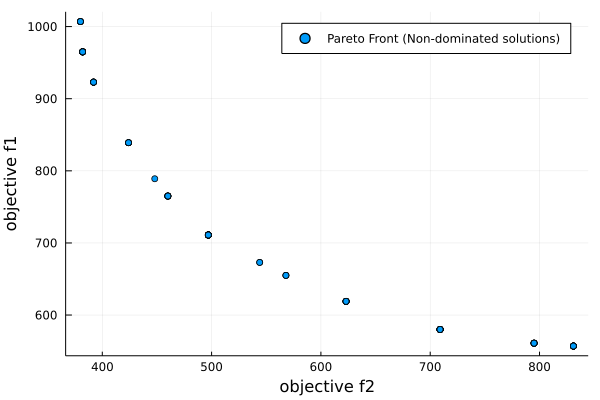

In [24]:
# Draw all the stuff
using Plots;

p1 = Plots.plot(γ_arr, τ_arr, label="Pareto Front (Non-dominated solutions)", seriestype=:scatter, xlabel="objective f2", ylabel="objective f1")
display(p1)
gui()

#### 

## Genetic Algorithm

In [17]:
## Nouvelle proposition (yohann)
using Random
using JuMP
using GLPK

cross_step = 10
current_step = 2

function paretofront_cost(n, c, t, couple)
        
  m=Model(GLPK.Optimizer)
  
  # Var binaires de décision (0= on prend pas)
  @variable(m, x[1:2n], Bin)
  ##on ne regarde qu'un objectif pour le moment
  @objective(m, Min, sum(c[i]*x[i] for i in 1:2n))
  #contrainte du nombre d'objets
  @constraint(m, sum(x[i] for i in 1:2n) == n)
  
  #on veut créer une nouvelle solution, on regarde celle directement supérieure en terme de cout
  @constraint(m, couple[1] + current_step <= sum(c[i]*x[i] for i in 1:2n))

  # Same thing here but with the other objective to stop laterral diffusion and go down
  @constraint(m, couple[2] + cross_step >= sum(t[i]*x[i] for i in 1:2n))
  
 
  
  #optimization 
  optimize!(m)
  push!(listes_couple, calcCostTime(value.(x)))
  return objective_value(m)
 end
  
function paretofront_tau(n, c, t, couple)
        
  m=Model(GLPK.Optimizer)
  
  # Var binaires de décision (0= on prend pas)
  @variable(m, x[1:2n], Bin)
  ##on ne regarde qu'un objectif pour le moment
  @objective(m, Min, sum(t[i]*x[i] for i in 1:2n))
  #contrainte du nombre d'objets
  @constraint(m, sum(x[i] for i in 1:2n) == n)
  #on veut créer une nouvelle solution, on regarde celle directement supérieure en terme de cout
  @constraint(m, sum(t[i]*x[i] for i in 1:2n)>= couple[2] + current_step)
  #test
  @constraint(m, couple[1] + cross_step >= sum(c[i]*x[i] for i in 1:2n))

 
  
  #optimization 
  optimize!(m)
  push!(listes_couple, calcCostTime(value.(x)))
  return objective_value(m)
 end

paretofront_tau (generic function with 1 method)

In [23]:
## boucle while de pareto
N = 450
function boucle()
  couple= (0,10000)
  for i in 1:1:N
    paretofront_cost(n,c,t,couple)
    couple=last(listes_couple)
  end
end
function boucle2()
  couple2=(10000,0)
  for i in 1:1:N
    paretofront_tau(n,c,t,couple2)
    couple2=last(listes_couple)
  end
end

boucle2 (generic function with 1 method)

In [24]:
function domi3()
  for j in listes_couple
    count = 0
    for i in listes_couple
      count += 1
      domine=isDominated(i, j)
      if domine == true
        break
      end
     end
     if count == length(listes_couple)
      push!(front, j)
     end
  end
end

domi3 (generic function with 1 method)

In [25]:
listes_couple=[]
boucle()
boucle2()
println(listes_couple)

front = []
domi3()
print(front)

Any[(1358.0, 2137.0), (1360.0, 2111.0), (1362.0, 2119.0), (1364.0, 2109.0), (1366.0, 2117.0), (1368.0, 2116.0), (1370.0, 2105.0), (1372.0, 2106.0), (1374.0, 2102.0), (1376.0, 2105.0), (1378.0, 2099.0), (1380.0, 2097.0), (1382.0, 2048.0), (1384.0, 1969.0), (1386.0, 1962.0), (1388.0, 1955.0), (1390.0, 1957.0), (1392.0, 1950.0), (1394.0, 1929.0), (1396.0, 1904.0), (1398.0, 1899.0), (1400.0, 1904.0), (1402.0, 1897.0), (1404.0, 1895.0), (1406.0, 1903.0), (1408.0, 1901.0), (1410.0, 1910.0), (1412.0, 1883.0), (1414.0, 1868.0), (1416.0, 1870.0), (1418.0, 1863.0), (1420.0, 1873.0), (1422.0, 1869.0), (1424.0, 1876.0), (1426.0, 1861.0), (1428.0, 1859.0), (1430.0, 1835.0), (1432.0, 1840.0), (1434.0, 1826.0), (1436.0, 1822.0), (1438.0, 1827.0), (1440.0, 1827.0), (1442.0, 1835.0), (1444.0, 1835.0), (1446.0, 1825.0), (1448.0, 1823.0), (1450.0, 1832.0), (1452.0, 1842.0), (1454.0, 1798.0), (1456.0, 1806.0), (1458.0, 1802.0), (1460.0, 1811.0), (1462.0, 1807.0), (1464.0, 1804.0), (1466.0, 1808.0), (1468.

2465.0, 881.0), (2472.0, 883.0), (2479.0, 885.0), (2476.0, 887.0), (2403.0, 889.0), (2395.0, 891.0), (2400.0, 893.0), (2388.0, 895.0), (2388.0, 897.0), (2394.0, 899.0), (2401.0, 901.0), (2351.0, 903.0), (2358.0, 905.0), (2312.0, 907.0), (2320.0, 909.0), (2326.0, 911.0), (2335.0, 913.0), (2345.0, 915.0), (2355.0, 917.0), (2334.0, 919.0), (2342.0, 921.0), (2347.0, 923.0), (2354.0, 925.0), (2363.0, 927.0), (2369.0, 929.0), (2376.0, 931.0), (2321.0, 933.0), (2329.0, 935.0), (2307.0, 937.0), (2314.0, 939.0), (2298.0, 941.0), (2286.0, 943.0), (2291.0, 945.0), (2291.0, 947.0), (2296.0, 949.0), (2293.0, 951.0), (2303.0, 953.0), (2308.0, 955.0), (2308.0, 957.0), (2297.0, 959.0), (2302.0, 961.0), (2302.0, 963.0), (2311.0, 965.0), (2297.0, 967.0), (2307.0, 969.0), (2299.0, 971.0), (2286.0, 973.0), (2295.0, 975.0), (2294.0, 977.0), (2283.0, 979.0), (2288.0, 981.0), (2296.0, 983.0), (2306.0, 985.0), (2276.0, 987.0), (2268.0, 989.0), (2197.0, 991.0), (2193.0, 993.0), (2200.0, 995.0), (2195.0, 997.0)

Any[(1358.0, 2137.0), (1360.0, 2111.0), (1364.0, 2109.0), (1370.0, 2105.0), (1374.0, 2102.0), (1378.0, 2099.0), (1380.0, 2097.0), (1382.0, 2048.0), (1384.0, 1969.0), (1386.0, 1962.0), (1388.0, 1955.0), (1392.0, 1950.0), (1394.0, 1929.0), (1396.0, 1904.0), (1398.0, 1899.0), (1402.0, 1897.0), (1404.0, 1895.0), (1412.0, 1883.0), (1414.0, 1868.0), (1418.0, 1863.0), (1426.0, 1861.0), (1428.0, 1859.0), (1430.0, 1835.0), (1434.0, 1826.0), (1436.0, 1822.0), (1454.0, 1798.0), (1470.0, 1754.0), (1494.0, 1748.0), (1496.0, 1729.0), (1498.0, 1719.0), (1500.0, 1694.0), (1562.0, 1688.0), (1564.0, 1664.0), (1584.0, 1648.0), (1588.0, 1647.0), (1590.0, 1567.0), (1596.0, 1563.0), (1602.0, 1545.0), (1610.0, 1542.0), (1666.0, 1522.0), (1688.0, 1495.0), (1692.0, 1445.0), (1694.0, 1418.0), (1700.0, 1404.0), (1722.0, 1398.0), (1724.0, 1390.0), (1728.0, 1387.0), (1732.0, 1382.0), (1738.0, 1379.0), (1740.0, 1363.0), (1840.0, 1334.0), (1864.0, 1310.0), (1876.0, 1285.0), (1986.0, 1170.0), (1996.0, 1151.0), (2513.

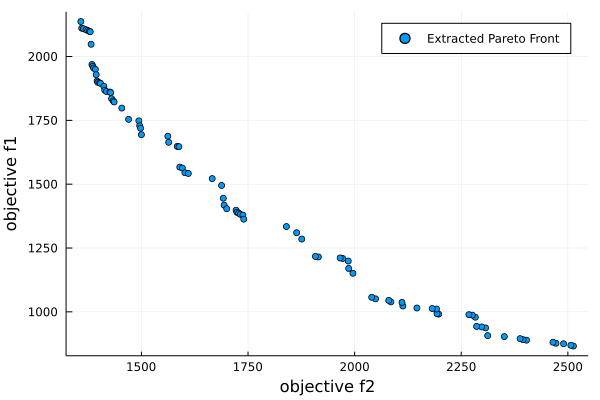

In [26]:
using Plots;

γ_arr_2 = Float64[]
τ_arr_2 = Float64[]


for i in front
  push!(γ_arr_2, i[1])
  push!(τ_arr_2, i[2])
end

p = Plots.plot(γ_arr_2, τ_arr_2, label="Extracted Pareto Front", seriestype=:scatter, xlabel="objective f2", ylabel="objective f1")

display(p)
gui()

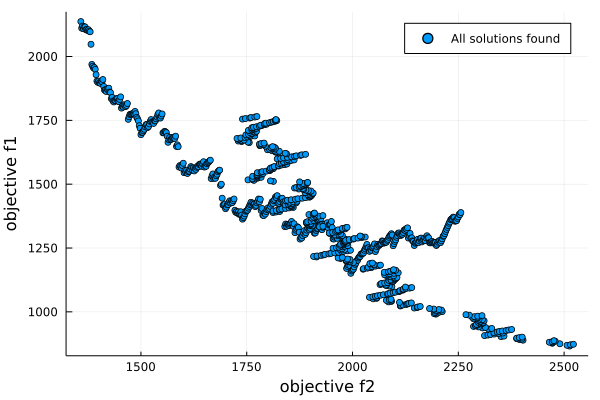

In [27]:
using Plots;

γ_arr_2 = Float64[]
τ_arr_2 = Float64[]


for i in listes_couple
  push!(γ_arr_2, i[1])
  push!(τ_arr_2, i[2])
end

p3 = Plots.plot(γ_arr_2, τ_arr_2, label="All solutions found", seriestype=:scatter, xlabel="objective f2", ylabel="objective f1")

display(p3)
gui()